In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt

In [2]:
# WHY DOESN'T THE INSTALL WORK????!!!!! >:O
import sys
sys.path.insert(1, '../tornado_mod')

In [130]:
import drift_detection.__init__ as detectors
detector_names = [d for d in dir(detectors) if (not d.startswith('__')) and (d != 'BDDM')]
detectors = [ getattr(detectors, d)() for d in detector_names ]

In [131]:
detectors

In [5]:
from classifier.__init__ import *
from drift_detection.__init__ import *

In [6]:
dir(CDDM)

['DETECTOR_NAME',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'detect',
 'get_settings',
 'reset',
 'run']

In [7]:
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa

In [8]:
from IPython.display import display, Markdown

In [11]:
plt.style.use('ggplot')

# Detection Delay and False Positive Rate Evaluation

In [152]:
######################################
##### BERNOULLI DATA STREAM CODE #####
######################################

import time
from pympler import asizeof

def generate_data(n_samples, p, rate=0.5):
    # p = [ Pr(y=1|x=0), Pr(y=1|x=1) ]
    # rate is proportion of x=1 (rather than x=0)
    x = np.array([ np.random.choice(2, p=[1-rate, rate]) for i in range(n_samples) ])
    y = [ np.random.choice(2, p=[1-p[i], p[i]]) for i in x ]
    x = x.reshape(-1, 1)

    return x, y

class Experiment:
    
    pre_drift_n = 1000
    post_drift_n = 1000
    
    def __init__(self, probs, detector, model, rates, parameter, mode):
        # probs = [a,b,c,d]
        # Before drift:
        # P(1|0) = a
        # P(1|1) = b
        # After drift:
        # P(1|0) = c
        # P(1|1) = d
        self.probs = probs
        self.detector = detector
        self.model = model
        self.mode = mode
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.runtime = None
        self.memory = None
        self.delay = 255 if mode=='real' else np.nan
        self.rates = rates
        self.parameter = parameter
        
    def run_experiment(self):
        x1, y1 = generate_data(Experiment.pre_drift_n, self.probs[:2], self.rates[0])
        x2, y2 = generate_data(Experiment.post_drift_n, self.probs[2:], self.rates[1])
        
        x = list(x1) + list(x2)
        y = list(y1) + list(y2)
        
        t1 = time.perf_counter()
        
        # return either none or the point of detection
        model = self.model
        model.reset()
#         if type(model)==str:
#             model = eval(model)()
        detector = self.detector
        detector.reset()
#         if type(detector)==str:
#             detector = eval(detector)()
        # Calibrate the detector
        for i in range(len(x)):
            y_ = y[i: i+1]
            x_ = x[i: i+1]
            
            pred = model.predict([x_])
            pr = pred==y_
            args = [pr]
            if detector.DETECTOR_NAME == "CDDM":
                proba = model.predict_proba(x_)
                conf = np.max(proba)
                args.append(conf)
                
            warning_status, drift_status = detector.detect(*args)
            
            if drift_status:
#                 print(f'{self.detector} detected a drift at {i}')
                if i>Experiment.pre_drift_n and i<Experiment.pre_drift_n+250 and \
                        self.mode=='real' and self.tp < 1:
                    self.tp += 1
                    self.delay = i - Experiment.pre_drift_n
                else:
                    self.fp += 1
                model.reset()
                detector.reset()
            
            model.partial_fit(x_, y_)
        
        t2 = time.perf_counter()
        delta_t = (t2 - t1) * 1000  # in milliseconds

        self.runtime = delta_t
        self.memory = asizeof.asizeof(detector, limit=20)
        if self.mode=='real' and self.tp < 1:
            self.fn += 1
    
    def get_result_row(self):
        return pd.DataFrame({'Experiment': self.detector.DETECTOR_NAME,
                             'Memory': self.memory,
                             'Runtime': self.runtime,
                             'Detection delay': self.delay,
                             'TP': self.tp,
                             'FP': self.fp,
                             'FN': self.fn,
                             'Parameter': [self.parameter]})

In [153]:
class NB: # Simple Naive Bayes Learner
    def __init__(self):
        self.reset()
    def partial_fit(self, x, y):
        for x_, y_ in zip(x, y):
            self.counts[x_[0]][y_] += 1
        return self
    def predict_proba(self, x):
        ret = []
        for x_ in x:
            while not type(x_)==np.int64 and not type(x_)==int:
                x_ = x_[0]
            ret.append( self.counts[x_]/np.sum(self.counts[x_]) )
        ret = np.array(ret)
        return ret
    def predict(self, x):
        probs = self.predict_proba(x)
        ret = [ max([0,1], key=lambda x: line[x]) for line in probs ]
        return ret
    def reset(self):
        self.counts = { 0: np.array([1,1]), 1: np.array([1,1])}

In [154]:
models = [NB()]

def experiment(probs, rates, param=None, repeats=10, **kwargs):
    results = pd.DataFrame(columns=['Experiment', 'Memory', 'Runtime', 'Detection delay', 'TP', 'FP', 'FN', 'Parameter'])
    for i in range(repeats):
        for detector in detectors:
            for model in models:
                exp = Experiment(probs, detector, model, rates, param, **kwargs)
                exp.run_experiment()
                results = results.append(exp.get_result_row())
    return results

## New Expeirments

In [155]:
def get_percentage_positive(results):
    experiments = list(results.Experiment.unique())
    ret = pd.DataFrame(columns=['Experiment', 'Parameter', 'Positive'])
    i = 1
    for exp in results.Experiment.unique():
        for param in results.Parameter.unique():
            subresults = results[(results.Experiment==exp) & (results.Parameter==param)]
            positives = [ i for i in subresults.Outcome if i!=None]
            ret.loc[i, :] = [exp, param, len(positives)/len(subresults)*100]
            i += 1
    ret['Experiment'] = ret['Experiment'].astype('category')
    ret['Parameter'] = ret['Parameter'].astype('float')
    ret['Positive'] = ret['Positive'].astype('float')
    return ret

In [156]:
target_dir = 'old_bernoulli'

In [161]:
def vdrift_experiment(p, epsilon=0.2):
    probs = [0, 1-epsilon, 0, 1-epsilon]
    rates = [p, 1-p]
    return experiment(probs, rates, param=p, repeats=10, mode='virtual')

def vdrift_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Memory', 'Runtime', 'Detection delay', 'TP', 'FP', 'FN', 'Parameter'])
    for p in np.linspace(0, 0.99, num=20):
        results = results.append(vdrift_experiment(p))
    return results

vdrift_results = vdrift_experiments()
for col in ['TP', 'FP', 'FN', 'Memory', 'Detection delay']:
    vdrift_results[col] = vdrift_results[col].astype(float)
vdrift_results.to_csv(os.path.join(target_dir, 'vdrift_results.csv'), index=False)

In [162]:
def rdrift_experiment(p, epsilon=0.2):
    probs = [0, 1-epsilon, 0, epsilon]
    rates = [p, 1-p]
    return experiment(probs, rates, param=p, repeats=10, mode='real')

def rdrift_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for p in np.linspace(0, 0.99, num=20):
        results = results.append(rdrift_experiment(p))
    return results

rdrift_results = rdrift_experiments()
for col in ['TP', 'FP', 'FN', 'Memory', 'Detection delay']:
    rdrift_results[col] = rdrift_results[col].astype(float)
rdrift_results.to_csv(os.path.join(target_dir, 'rdrift_results.csv'), index=False)

In [216]:
results = vdrift_results.append(rdrift_results)
results.drop(columns='Outcome', inplace=True)
results.rename(columns={'Experiment': 'Detector'}, inplace=True)

In [218]:
before_after = {
    'Mean Delay': 'Mean Delay',
    'Memory': 'Memory (bytes)',
    'Runtime': 'Runtime (ms)',
    'Err-rate': 'Err-rate (\%)',
    'PageHinkley': 'PH',
    'FHDDMS.add': 'FHDDMS$_{add}$',
    'MDDM.A.100': 'MDDM$_A$',
    'MDDM.E.100': 'MDDM$_E$',
    'MDDM.G.100': 'MDDM$_G$',
    'NO\_DETECTION': 'Null',
    'NO_DETECTION': 'Null',
    'NAIVE BAYES': 'NB',
    'PERCEPTRON': 'PR',
    'HOEFFDING TREE': 'HT',
    'LEDConceptDrift': 'LED',
    '\{bf ': '{\\fontseries{b}\\selectfont ',
    '\}': '}'
}

before_after.update({
    f'HDDM.{x}.test': f'HDDM$_{x}$' for x in 'AW'
})

results['Detector'] = results['Detector'].replace(before_after).fillna(results['Detector'])

In [219]:
results

,Detector,Memory,Runtime,Detection delay,TP,FP,FN,Parameter
0,ADWIN,6656.0,83.935058,NaN,0.0,1.0,0.0,0.00
0,BWAF,1024.0,107.597090,NaN,0.0,2.0,0.0,0.00
0,CDDM,8944.0,100.325020,NaN,0.0,0.0,0.0,0.00
0,CUSUM,880.0,38.973275,NaN,0.0,1.0,0.0,0.00
0,DDM,904.0,37.546714,NaN,0.0,1.0,0.0,0.00
...,...,...,...,...,...,...,...,...
0,MDDM$_G$,1968.0,69.164227,255.0,0.0,0.0,1.0,0.99
0,Null,320.0,33.214285,255.0,0.0,0.0,1.0,0.99
0,PH,960.0,36.037560,255.0,0.0,0.0,1.0,0.99
0,RDDM,63944.0,49.690417,255.0,0.0,0.0,1.0,0.99


In [220]:
# Take totals for each detector/parameter pair
results = results.groupby(['Detector', 'Parameter']).agg({
    'Memory': 'mean', 'Runtime': 'mean', 
    'Detection delay': np.nanmean, 'TP': 'sum', 
    'FP': 'sum', 'FN': 'mean'
}).reset_index()

# Compute precision/recall
for col in ['TP', 'FP', 'FN']: # laplace smoothing
    results[col] += 1
tp, fp, fn = results['TP'], results['FP'], results['FN']
results['Precision'] = tp / (tp+fp)
results['Recall'] = tp / (tp+fn)
results['F1'] = 2 * 1/(1/results['Precision'] + 1/results['Recall'])

results

,Detector,Parameter,Memory,Runtime,Detection delay,TP,FP,FN,Precision,Recall
0,ADWIN,0.000000,6598.4,69.863514,74.2,11.0,11.0,1.0,0.500000,0.916667
1,ADWIN,0.052105,6572.4,66.959125,23.0,11.0,11.0,1.0,0.500000,0.916667
2,ADWIN,0.104211,6564.0,66.893499,23.0,11.0,11.0,1.0,0.500000,0.916667
3,ADWIN,0.156316,6572.4,67.244699,23.0,11.0,11.0,1.0,0.500000,0.916667
4,ADWIN,0.208421,6555.2,67.491683,26.2,11.0,11.0,1.0,0.500000,0.916667
...,...,...,...,...,...,...,...,...,...,...
375,SeqDrift2,0.781579,49592.0,47.011306,255.0,1.0,11.0,1.5,0.083333,0.400000
376,SeqDrift2,0.833684,50256.0,46.469818,255.0,1.0,11.0,1.5,0.083333,0.400000
377,SeqDrift2,0.885789,42902.4,48.330100,243.8,3.0,12.0,1.4,0.200000,0.681818
378,SeqDrift2,0.937895,30272.0,47.050589,199.0,11.0,11.0,1.0,0.500000,0.916667


In [221]:
all_detectors = results.Detector.unique()
l_detectors = all_detectors[:len(all_detectors)//2]
r_detectors = all_detectors[len(all_detectors)//2:]
l_results = results[ results['Detector'].isin(l_detectors) ]
r_results = results[ results['Detector'].isin(r_detectors) ]

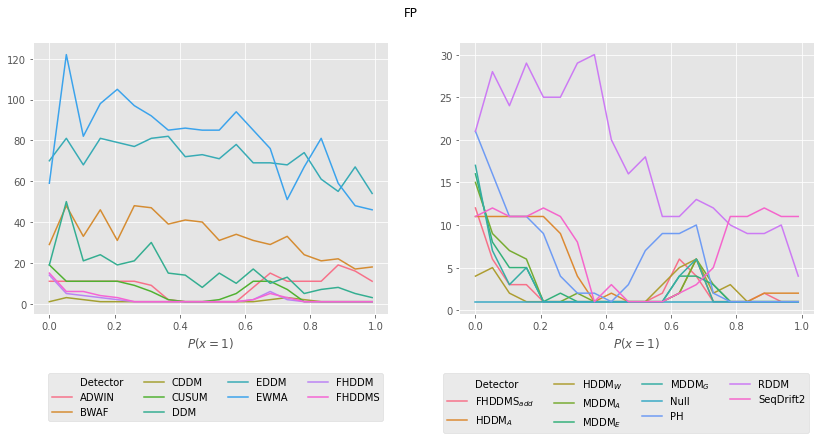

In [255]:
col = 'FP'

plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
g = sns.lineplot(x='Parameter', y=col, hue='Detector', data=l_results, ax=ax1);
g.legend(bbox_to_anchor=(1,-0.2), ncol=4)
g.set(ylabel='', xlabel='$P(x=1)$')
g = sns.lineplot(x='Parameter', y=col, hue='Detector', data=r_results, ax=ax2);
g.legend(bbox_to_anchor=(1,-0.2), ncol=4)
g.set(ylabel='', xlabel='$P(x=1)$')
plt.suptitle(col);

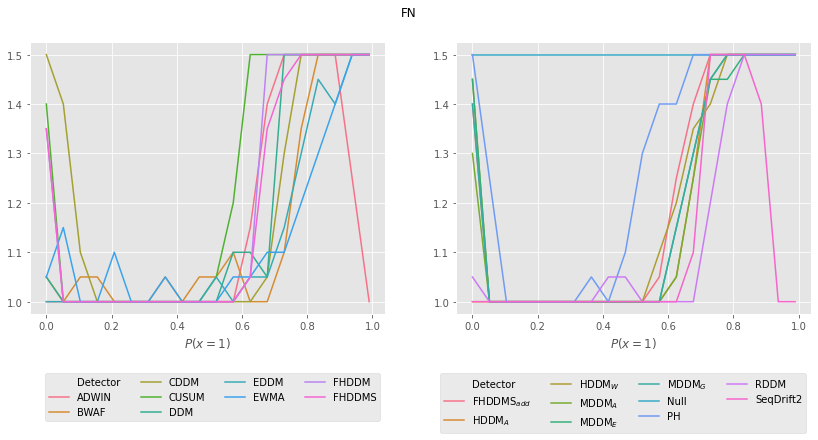

In [252]:
col = 'FN'

plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
g = sns.lineplot(x='Parameter', y=col, hue='Detector', data=l_results, ax=ax1);
g.legend(bbox_to_anchor=(1,-0.2), ncol=4)
g.set(ylabel='', xlabel='$P(x=1)$')
g = sns.lineplot(x='Parameter', y=col, hue='Detector', data=r_results, ax=ax2);
g.legend(bbox_to_anchor=(1,-0.2), ncol=4)
g.set(ylabel='', xlabel='$P(x=1)$')
plt.suptitle(col);

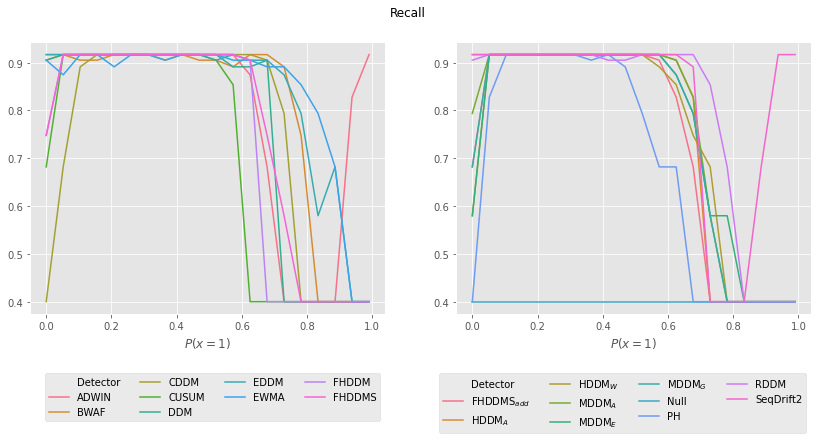

In [253]:
col = 'Recall'

plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
g = sns.lineplot(x='Parameter', y=col, hue='Detector', data=l_results, ax=ax1);
g.legend(bbox_to_anchor=(1,-0.2), ncol=4)
g.set(ylabel='', xlabel='$P(x=1)$')
g = sns.lineplot(x='Parameter', y=col, hue='Detector', data=r_results, ax=ax2);
g.legend(bbox_to_anchor=(1,-0.2), ncol=4)
g.set(ylabel='', xlabel='$P(x=1)$')
plt.suptitle(col);

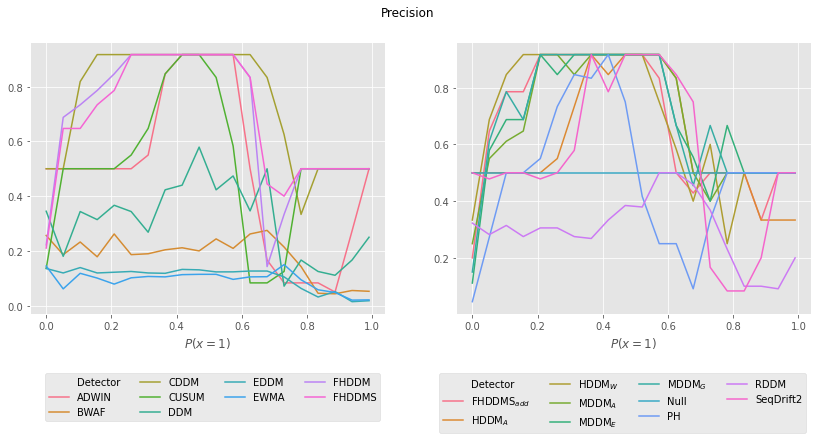

In [256]:
col = 'Precision'

plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
g = sns.lineplot(x='Parameter', y=col, hue='Detector', data=l_results, ax=ax1);
g.legend(bbox_to_anchor=(1,-0.2), ncol=4)
g.set(ylabel='', xlabel='$P(x=1)$')
g = sns.lineplot(x='Parameter', y=col, hue='Detector', data=r_results, ax=ax2);
g.legend(bbox_to_anchor=(1,-0.2), ncol=4)
g.set(ylabel='', xlabel='$P(x=1)$')
plt.suptitle('Precision');

In [257]:
results

,Detector,Parameter,Memory,Runtime,Detection delay,TP,FP,FN,Precision,Recall
0,ADWIN,0.000000,6598.4,69.863514,74.2,11.0,11.0,1.0,0.500000,0.916667
1,ADWIN,0.052105,6572.4,66.959125,23.0,11.0,11.0,1.0,0.500000,0.916667
2,ADWIN,0.104211,6564.0,66.893499,23.0,11.0,11.0,1.0,0.500000,0.916667
3,ADWIN,0.156316,6572.4,67.244699,23.0,11.0,11.0,1.0,0.500000,0.916667
4,ADWIN,0.208421,6555.2,67.491683,26.2,11.0,11.0,1.0,0.500000,0.916667
...,...,...,...,...,...,...,...,...,...,...
375,SeqDrift2,0.781579,49592.0,47.011306,255.0,1.0,11.0,1.5,0.083333,0.400000
376,SeqDrift2,0.833684,50256.0,46.469818,255.0,1.0,11.0,1.5,0.083333,0.400000
377,SeqDrift2,0.885789,42902.4,48.330100,243.8,3.0,12.0,1.4,0.200000,0.681818
378,SeqDrift2,0.937895,30272.0,47.050589,199.0,11.0,11.0,1.0,0.500000,0.916667


In [260]:
results.index.map(lambda x: x%20)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
           dtype='int64', length=380)

In [268]:
n_trials = 20
results['dataset_name'] = results['Parameter'].map(lambda x: str(x)) + results.index.map(lambda x: str(x%n_trials))
results.rename(columns={'Detection delay': 'Mean Delay'}, inplace=True)
results_ready = results[['Detector', 'dataset_name', 'Precision', 'Recall', 'F1', 'Mean Delay', 'Memory', 'Runtime']]

In [269]:
category = 'bernoulli'

In [271]:
import parse_results
from importlib import reload 
parse_results = reload(parse_results)
process_results = parse_results.process_results

Writing LaTeX table to tables/bernoulli.tex
Processing Precision


/anaconda3/envs/triage_drift_env/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Post-hocs computed.
Average vals computed.
Completed plot for Precision
Processing Recall
Post-hocs computed.
Average vals computed.
Completed plot for Recall
Processing F1
Post-hocs computed.
Average vals computed.
Completed plot for F1
Processing Mean Delay
Post-hocs computed.
Average vals computed.
Completed plot for Mean Delay
Processing Memory
Post-hocs computed.
Average vals computed.
Completed plot for Memory
Processing Runtime
Post-hocs computed.
Average vals computed.
Completed plot for Runtime
Writing cd diagrams to figures/bernoulli.pdf


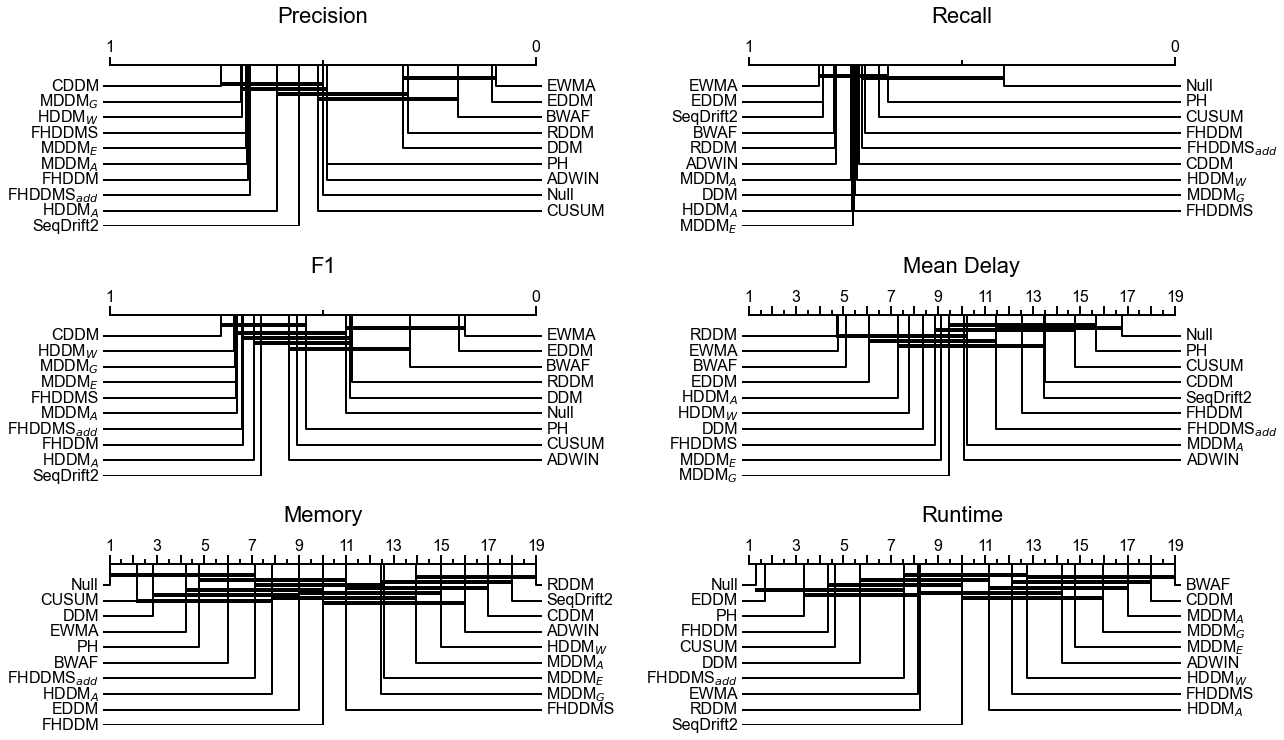

In [272]:
latex = process_results(
    results_ready, 
    groupby='Detector', 
    latex_path=f'tables/{category}.tex',
    fig_path=f'figures/{category}.pdf',
    bold_best=True,
    alpha=0.05
)